<a href="https://www.kaggle.com/code/heartzhacker/resnet50-modified-architecture?scriptVersionId=180411564" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix

clahe_train1_path = "/kaggle/input/clahe-dataset/train1"
clahe_train2_path = "/kaggle/input/clahe-dataset/train2"
clahe_train3_path = "/kaggle/input/clahe-dataset/train3"
clahe_val_path = "/kaggle/input/clahe-dataset/val"
clahe_test_path = "/kaggle/input/clahe-test"


train1_path = "/kaggle/input/dataset/archive/train1"
train2_path = "/kaggle/input/dataset/archive/train2"
train3_path = "/kaggle/input/dataset/archive/train3"
val_path = "/kaggle/input/dataset/archive/val"
test_path = "/kaggle/input/testfile/test"

2024-05-29 10:38:03.563092: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 10:38:03.563181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 10:38:03.690943: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train1_generator = train_datagen.flow_from_directory(
    train1_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
clahe_train1_generator = train_datagen.flow_from_directory(
    clahe_train1_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

clahe_val_generator = val_datagen.flow_from_directory(
    clahe_val_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Add, Activation, BatchNormalization
from tensorflow.keras.models import Model

def conv_block(input_tensor, filters, kernel_size=3, strides=1):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def identity_block(input_tensor, filters):
    x = conv_block(input_tensor, filters, kernel_size=1)
    x = conv_block(x, filters, kernel_size=3)
    x = Conv2D(4 * filters, kernel_size=1)(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv2D(4 * filters, kernel_size=1)(input_tensor)  # Adjust dimensions
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_model(input_shape=(224, 224, 3)):
    weights_path = '/kaggle/input/resnet50-notop/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
    base_model = ResNet50(weights=weights_path, include_top=False, input_shape=input_shape)

    for layer in base_model.layers[:-3]:
        layer.trainable = False

    x = base_model.output
    x = conv_block(x, 1024, kernel_size=1)
    x = identity_block(x, 1024)
    x = identity_block(x, 1024)
    x = identity_block(x, 1024)

    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [6]:
from tensorflow.keras.optimizers import Adam

model_1 = build_model()
model_1.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 115,120,418 (439.15 MB)

 Trainable params: 91,473,314 (348.94 MB)

 Non-trainable params: 23,647,104 (90.21 MB)

In [7]:
from tensorflow.keras.optimizers import Adam

model_2 = build_model()
model_2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 115,120,418 (439.15 MB)

 Trainable params: 91,473,314 (348.94 MB)

 Non-trainable params: 23,647,104 (90.21 MB)

In [8]:
history_train1 = model_1.fit(
    train1_generator,
    epochs= 25, 
    validation_data=val_generator
)

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1716979141.465484      95 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94/94 ━━━━━━━━━━━━━━━━━━━━ 87s 541ms/step - accuracy: 0.5395 - loss: 1.9524 - val_accuracy: 0.5000 - val_loss: 0.6940
Epoch 2/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 220ms/step - accuracy: 0.6562 - loss: 0.6490 - val_accuracy: 0.5000 - val_loss: 0.8127
Epoch 3/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 221ms/step - accuracy: 0.7136 - loss: 0.5979 - val_accuracy: 0.6180 - val_loss: 0.6302
Epoch 4/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 220ms/step - accuracy: 0.7113 - loss: 0.5853 - val_accuracy: 0.5940 - val_loss: 0.7364
Epoch 5/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.7628 - loss: 0.4983 - val_accuracy: 0.6270 - val_loss: 0.7282
Epoch 6/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.8048 - loss: 0.4326 - val_accuracy: 0.5660 - val_loss: 1.1788
Epoch 7/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.8131 - loss: 0.4183 - val_accuracy: 0.7510 - val_loss: 0.4882
Epoch 8/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.8268 - loss: 0.3639 - val_accuracy: 0.636

In [9]:
history_clahe_train1 = model_2.fit(
    clahe_train1_generator,
    epochs= 25, 
    validation_data=clahe_val_generator
)

Epoch 1/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 64s 426ms/step - accuracy: 0.5750 - loss: 1.5506 - val_accuracy: 0.5000 - val_loss: 0.6916
Epoch 2/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 226ms/step - accuracy: 0.6828 - loss: 0.5945 - val_accuracy: 0.5000 - val_loss: 0.6918
Epoch 3/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - accuracy: 0.7286 - loss: 0.5501 - val_accuracy: 0.6900 - val_loss: 0.6129
Epoch 4/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - accuracy: 0.7271 - loss: 0.5284 - val_accuracy: 0.5920 - val_loss: 0.7015
Epoch 5/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.8037 - loss: 0.4205 - val_accuracy: 0.7310 - val_loss: 0.5379
Epoch 6/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 226ms/step - accuracy: 0.8189 - loss: 0.3963 - val_accuracy: 0.6270 - val_loss: 0.8317
Epoch 7/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - accuracy: 0.8369 - loss: 0.3601 - val_accuracy: 0.6370 - val_loss: 0.8407
Epoch 8/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 226ms/step - accuracy: 0.8763 - loss: 0.2836 - val_accu

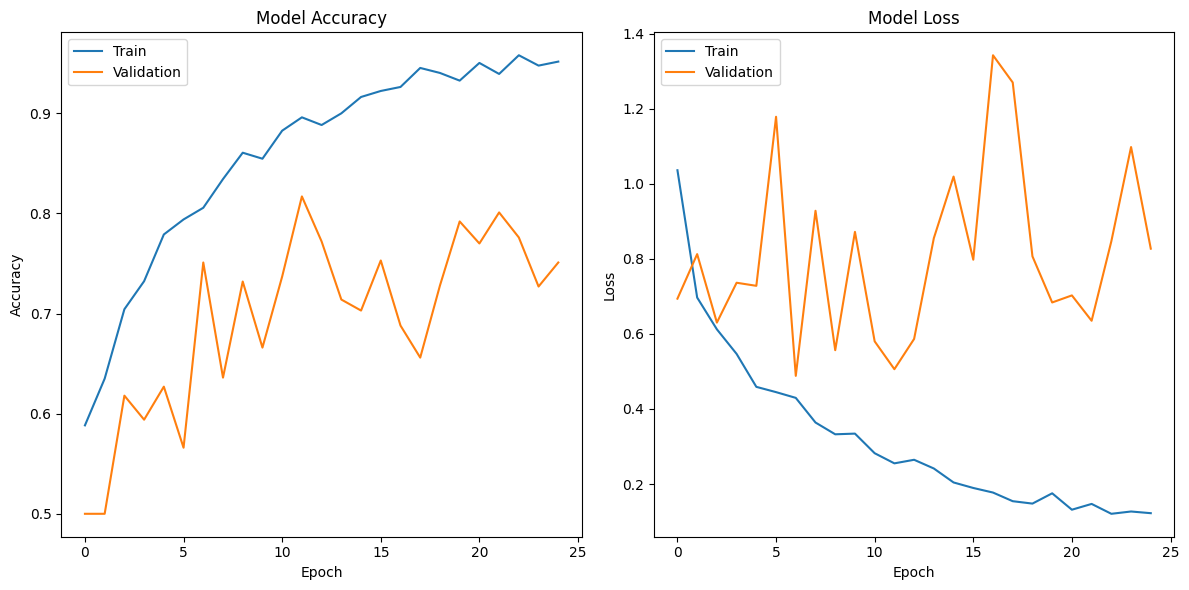

In [10]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_train1.history['accuracy'])
plt.plot(history_train1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history_train1.history['loss'])
plt.plot(history_train1.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [11]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 400 images belonging to 2 classes.


In [12]:
predictions = model_1.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 927ms/step



Classification Report:
              precision    recall  f1-score   support

 normal-ceum       0.88      0.50      0.64       200
      polyps       0.65      0.94      0.77       200

    accuracy                           0.72       400
   macro avg       0.77      0.72      0.70       400
weighted avg       0.77      0.72      0.70       400


Confusion Matrix:
[[100 100]
 [ 13 187]]


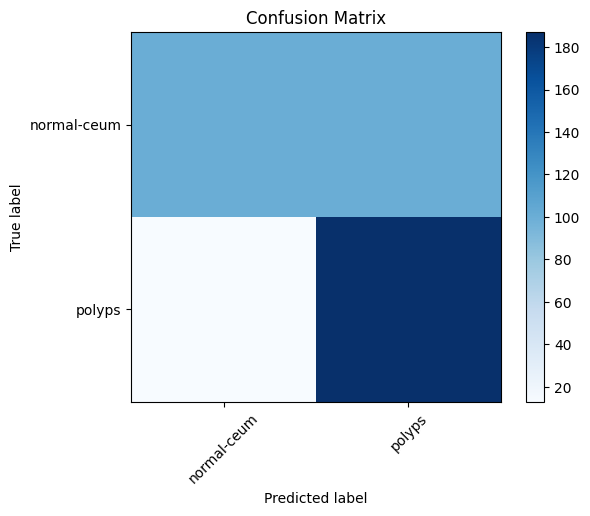

In [13]:
class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

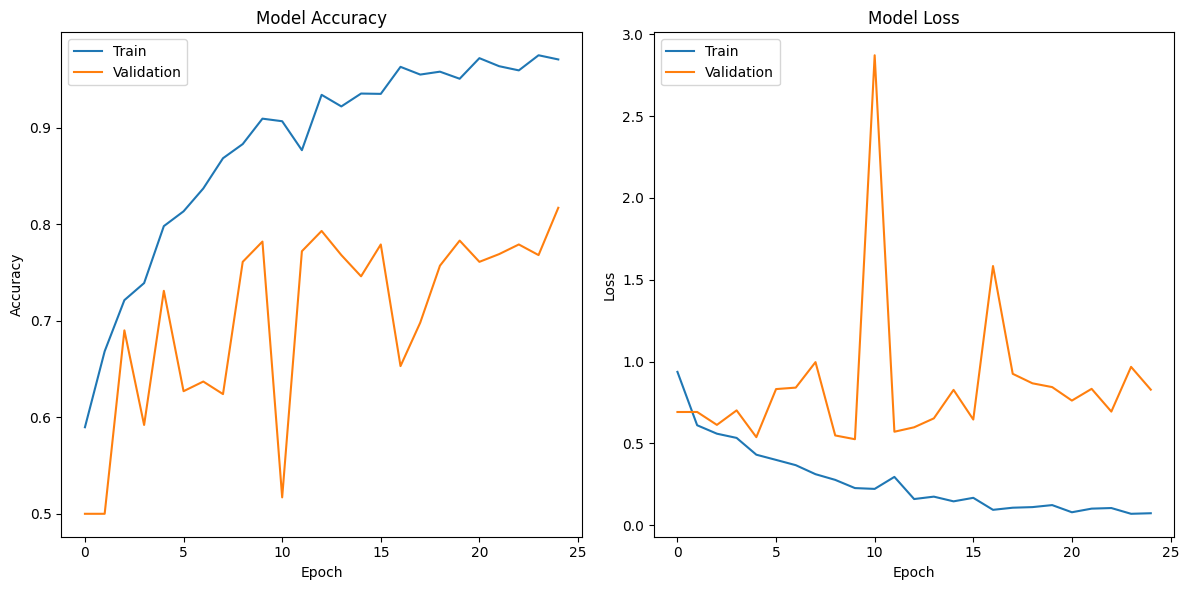

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_clahe_train1.history['accuracy'])
plt.plot(history_clahe_train1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history_clahe_train1.history['loss'])
plt.plot(history_clahe_train1.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [15]:
clahe_test_generator = test_datagen.flow_from_directory(
    clahe_test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 400 images belonging to 2 classes.


In [16]:
predictions = model_2.predict(clahe_test_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = clahe_test_generator.classes

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 546ms/step



Classification Report:
              precision    recall  f1-score   support

 normal-ceum       0.79      0.92      0.85       200
      polyps       0.90      0.75      0.82       200

    accuracy                           0.83       400
   macro avg       0.84      0.83      0.83       400
weighted avg       0.84      0.83      0.83       400


Confusion Matrix:
[[183  17]
 [ 50 150]]


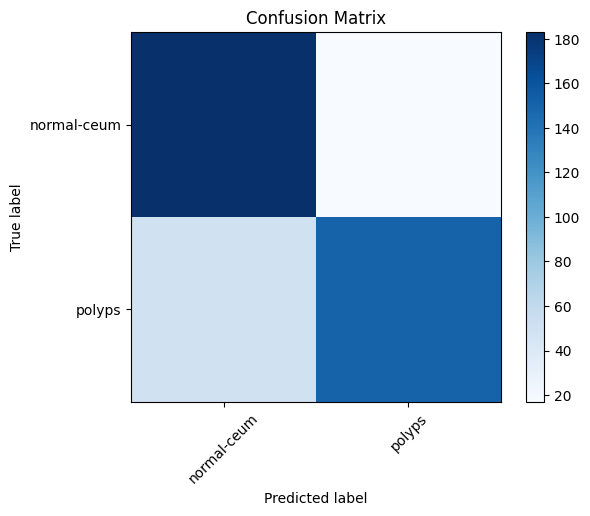

In [17]:
class_names = list(clahe_test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [18]:
model_weights_path = "/kaggle/working/train1.weights.h5"
model_1.save_weights(model_weights_path)

In [19]:
model_weights_path = "/kaggle/working/clahe_train1.weights.h5"
model_2.save_weights(model_weights_path)

In [20]:
train2_generator = train_datagen.flow_from_directory(
    train2_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

clahe_train2_generator = train_datagen.flow_from_directory(
    clahe_train2_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


In [21]:
history_train2 = model_1.fit(
    train2_generator,
    epochs=25,  
    validation_data=val_generator
)

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.7573 - loss: 0.5926 - val_accuracy: 0.7300 - val_loss: 0.5941
Epoch 2/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 221ms/step - accuracy: 0.8359 - loss: 0.3764 - val_accuracy: 0.5620 - val_loss: 1.2111
Epoch 3/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.8864 - loss: 0.2767 - val_accuracy: 0.7130 - val_loss: 0.6588
Epoch 4/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 220ms/step - accuracy: 0.8916 - loss: 0.2664 - val_accuracy: 0.8290 - val_loss: 0.4073
Epoch 5/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step - accuracy: 0.9170 - loss: 0.2134 - val_accuracy: 0.7600 - val_loss: 0.6464
Epoch 6/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.9258 - loss: 0.1821 - val_accuracy: 0.7280 - val_loss: 0.8166
Epoch 7/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.9230 - loss: 0.1852 - val_accuracy: 0.6120 - val_loss: 2.0218
Epoch 8/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 217ms/step - accuracy: 0.9353 - loss: 0.1565 - val_accuracy: 0.812

In [22]:
history_clahe_train2 = model_2.fit(
    clahe_train2_generator,
    epochs=25,  
    validation_data=clahe_val_generator
)

Epoch 1/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 245ms/step - accuracy: 0.7362 - loss: 0.6803 - val_accuracy: 0.7480 - val_loss: 0.5277
Epoch 2/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 227ms/step - accuracy: 0.8288 - loss: 0.3966 - val_accuracy: 0.6880 - val_loss: 0.5820
Epoch 3/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - accuracy: 0.8611 - loss: 0.3304 - val_accuracy: 0.7910 - val_loss: 0.4449
Epoch 4/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.8931 - loss: 0.2659 - val_accuracy: 0.7210 - val_loss: 0.5903
Epoch 5/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - accuracy: 0.9288 - loss: 0.1931 - val_accuracy: 0.6990 - val_loss: 0.7518
Epoch 6/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - accuracy: 0.9213 - loss: 0.1873 - val_accuracy: 0.7900 - val_loss: 0.5604
Epoch 7/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.9438 - loss: 0.1485 - val_accuracy: 0.7910 - val_loss: 0.5669
Epoch 8/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - accuracy: 0.9357 - loss: 0.1494 - val_accu

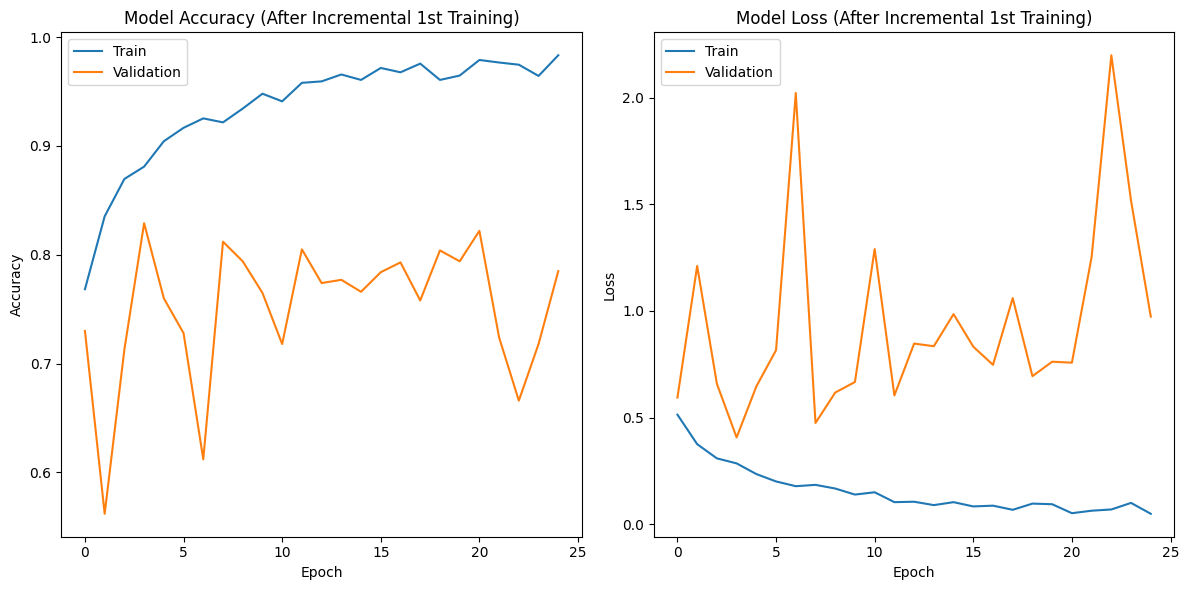

In [23]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_train2.history['accuracy'])
plt.plot(history_train2.history['val_accuracy'])
plt.title('Model Accuracy (After Incremental 1st Training)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_train2.history['loss'])
plt.plot(history_train2.history['val_loss'])
plt.title('Model Loss (After Incremental 1st Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [24]:
predictions = model_1.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step



Classification Report:
              precision    recall  f1-score   support

 normal-ceum       0.78      0.89      0.83       200
      polyps       0.87      0.76      0.81       200

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400


Confusion Matrix:
[[178  22]
 [ 49 151]]


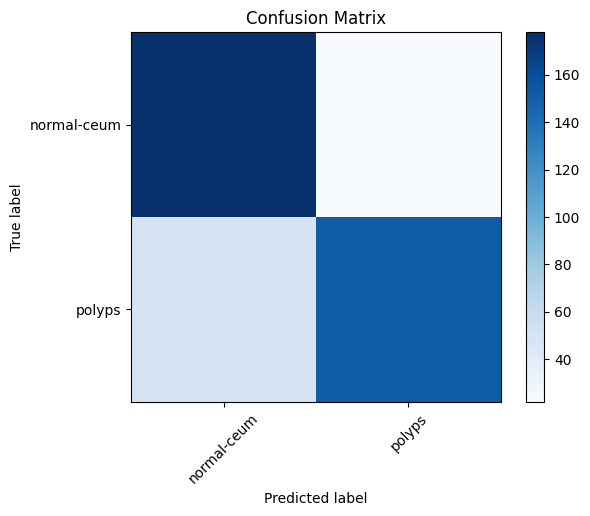

In [25]:
class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

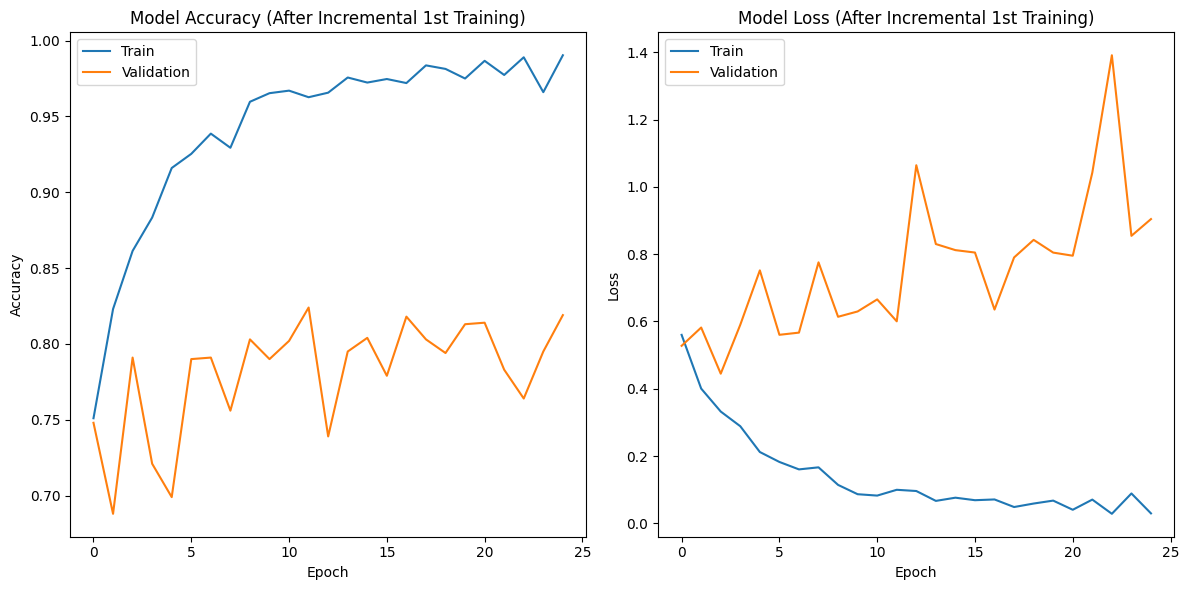

In [26]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_clahe_train2.history['accuracy'])
plt.plot(history_clahe_train2.history['val_accuracy'])
plt.title('Model Accuracy (After Incremental 1st Training)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_clahe_train2.history['loss'])
plt.plot(history_clahe_train2.history['val_loss'])
plt.title('Model Loss (After Incremental 1st Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [27]:
predictions = model_2.predict(clahe_test_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = clahe_test_generator.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step



Classification Report:
              precision    recall  f1-score   support

 normal-ceum       0.85      0.85      0.85       200
      polyps       0.85      0.84      0.85       200

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400


Confusion Matrix:
[[170  30]
 [ 31 169]]


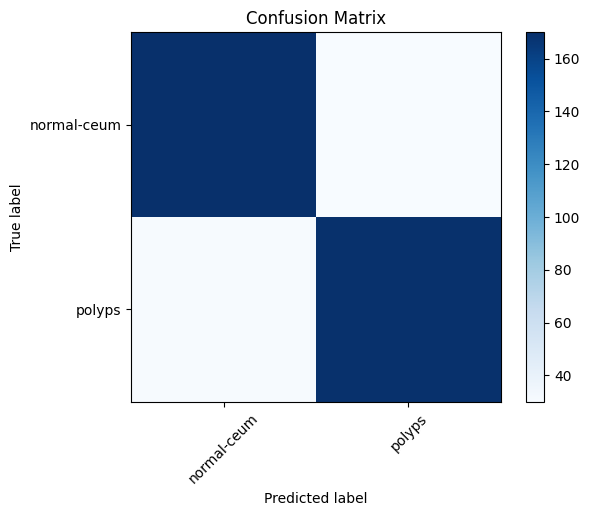

In [28]:
class_names = list(clahe_test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [29]:
model_weights_path = "/kaggle/working/train2.weights.h5"
model_1.save_weights(model_weights_path)

In [30]:
model_weights_path = "/kaggle/working/clahe_train2.weights.h5"
model_2.save_weights(model_weights_path)

In [31]:
train3_generator = train_datagen.flow_from_directory(
    train3_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

clahe_train3_generator = train_datagen.flow_from_directory(
    clahe_train3_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


In [32]:
history_train3 = model_1.fit(
    train3_generator,
    epochs=25,  
    validation_data=val_generator
)

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.7641 - loss: 0.5749 - val_accuracy: 0.7440 - val_loss: 0.5236
Epoch 2/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.8332 - loss: 0.3625 - val_accuracy: 0.7730 - val_loss: 0.4678
Epoch 3/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 0.8726 - loss: 0.2879 - val_accuracy: 0.7220 - val_loss: 0.6833
Epoch 4/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 218ms/step - accuracy: 0.9006 - loss: 0.2533 - val_accuracy: 0.7320 - val_loss: 0.7665
Epoch 5/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.9210 - loss: 0.1988 - val_accuracy: 0.7820 - val_loss: 0.5107
Epoch 6/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.9388 - loss: 0.1621 - val_accuracy: 0.7810 - val_loss: 0.6476
Epoch 7/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 221ms/step - accuracy: 0.9257 - loss: 0.1789 - val_accuracy: 0.7970 - val_loss: 0.5731
Epoch 8/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.9437 - loss: 0.1462 - val_accuracy: 0.829

In [33]:
history_clahe_train3 = model_2.fit(
    clahe_train3_generator,
    epochs=25,  
    validation_data=clahe_val_generator
)

Epoch 1/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 246ms/step - accuracy: 0.7663 - loss: 0.6314 - val_accuracy: 0.8400 - val_loss: 0.4354
Epoch 2/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 227ms/step - accuracy: 0.8408 - loss: 0.3517 - val_accuracy: 0.8180 - val_loss: 0.4431
Epoch 3/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.8939 - loss: 0.2609 - val_accuracy: 0.7970 - val_loss: 0.5432
Epoch 4/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.9057 - loss: 0.2273 - val_accuracy: 0.7700 - val_loss: 0.7062
Epoch 5/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 225ms/step - accuracy: 0.9371 - loss: 0.1546 - val_accuracy: 0.8010 - val_loss: 0.5353
Epoch 6/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.9480 - loss: 0.1264 - val_accuracy: 0.7930 - val_loss: 0.6523
Epoch 7/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 225ms/step - accuracy: 0.9632 - loss: 0.0941 - val_accuracy: 0.8320 - val_loss: 0.5184
Epoch 8/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.9674 - loss: 0.0941 - val_accu

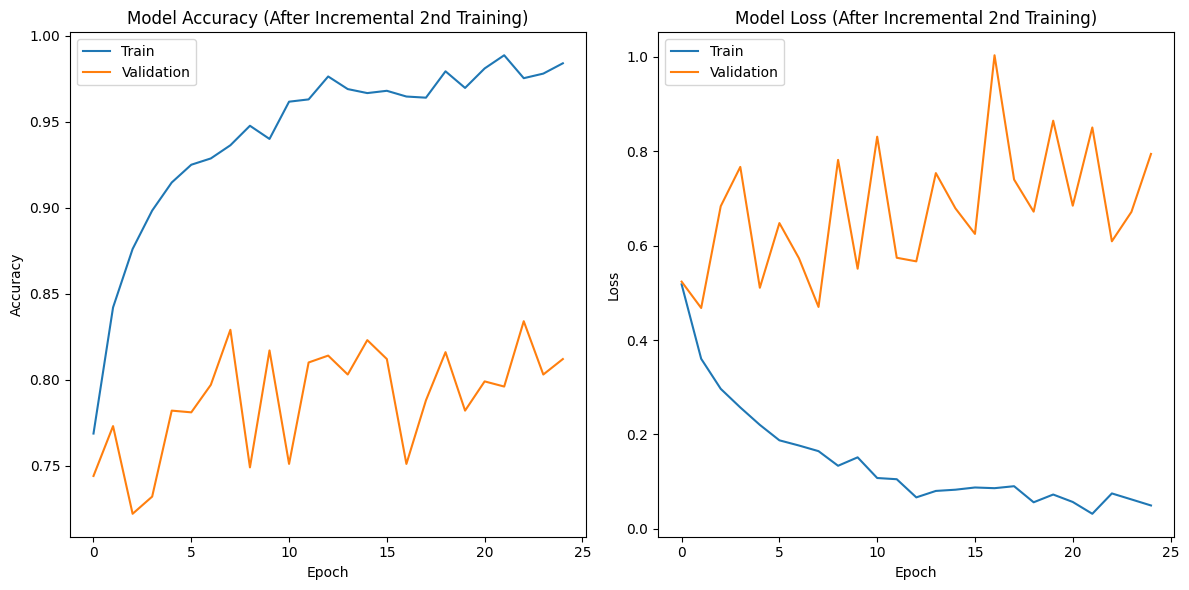

In [34]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_train3.history['accuracy'])
plt.plot(history_train3.history['val_accuracy'])
plt.title('Model Accuracy (After Incremental 2nd Training)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_train3.history['loss'])
plt.plot(history_train3.history['val_loss'])
plt.title('Model Loss (After Incremental 2nd Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [35]:
predictions = model_1.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step



Classification Report:
              precision    recall  f1-score   support

 normal-ceum       0.88      0.76      0.81       200
      polyps       0.79      0.90      0.84       200

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400


Confusion Matrix:
[[151  49]
 [ 20 180]]


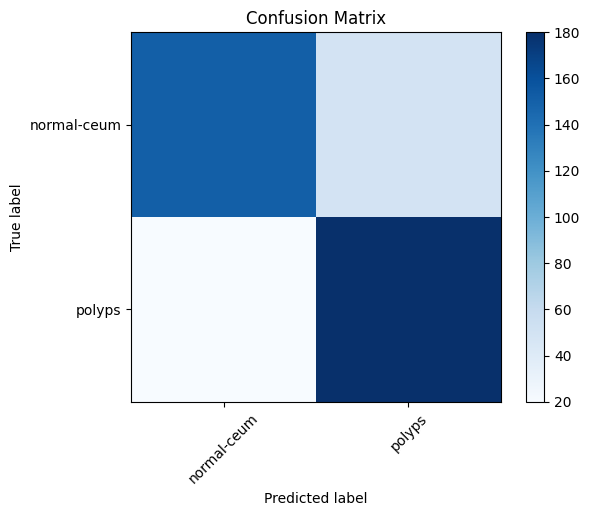

In [36]:
class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

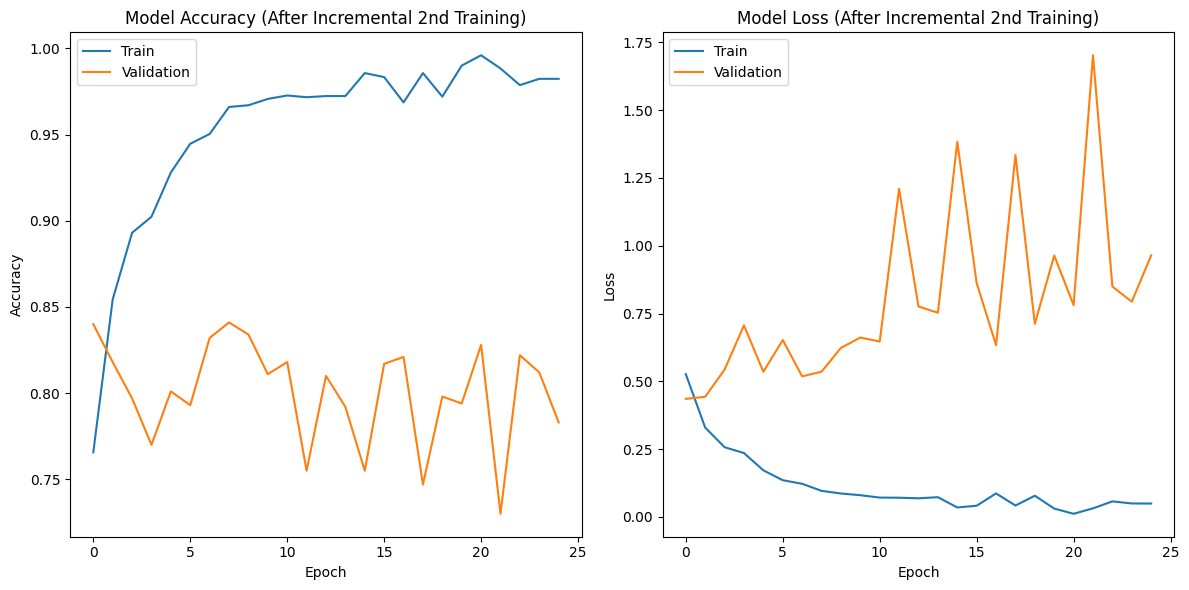

In [37]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_clahe_train3.history['accuracy'])
plt.plot(history_clahe_train3.history['val_accuracy'])
plt.title('Model Accuracy (After Incremental 2nd Training)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_clahe_train3.history['loss'])
plt.plot(history_clahe_train3.history['val_loss'])
plt.title('Model Loss (After Incremental 2nd Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [38]:
predictions = model_2.predict(clahe_test_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = clahe_test_generator.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step



Classification Report:
              precision    recall  f1-score   support

 normal-ceum       0.88      0.82      0.85       200
      polyps       0.84      0.89      0.86       200

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400


Confusion Matrix:
[[165  35]
 [ 22 178]]


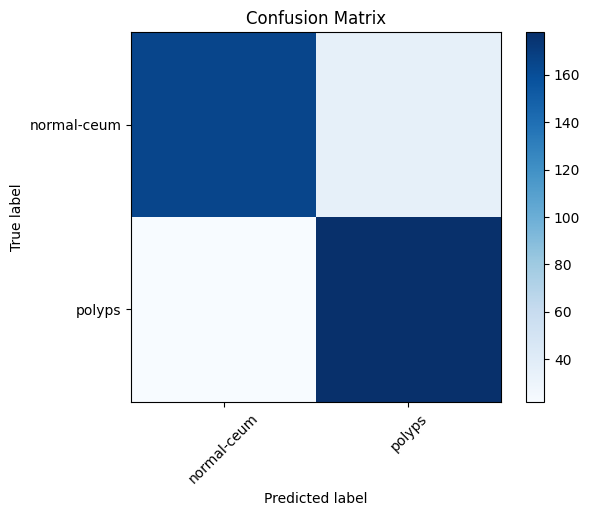

In [39]:
class_names = list(clahe_test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [40]:
model_weights_path = "/kaggle/working/train3.weights.h5"
model_1.save_weights(model_weights_path)

In [41]:
model_weights_path = "/kaggle/working/clahe_train3.weights.h5"
model_2.save_weights(model_weights_path)